In [120]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import layers
import os
from sklearn.model_selection import train_test_split

In [121]:
from sklearn import datasets
face_dataset = datasets.fetch_lfw_people(min_faces_per_person=50)
IMAGE_SIZE = face_dataset.images[0].shape 

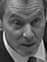

In [127]:
# Show the first image in the image dataset
first_image = face_dataset.images[0]
img = keras.preprocessing.image.array_to_img(np.expand_dims(first_image * 255, axis=-1))
display(img)

In [222]:
# filter out images if they're the > 150th image for a class -- don't want too many of some classes
kept_images = []
kept_labels = []
frequencies = {}

for image, label in zip(face_dataset.images, face_dataset.target):
    if label not in frequencies:
        frequencies[label] = 0
    if frequencies[label] > 150:
        continue
    kept_images.append(image)
    kept_labels.append(label)
    frequencies[label] += 1

In [223]:
# remap labels from [0, N - 1]

old_labels_to_new_labels = {}
for label in kept_labels:
    if label not in old_labels_to_new_labels:
        old_labels_to_new_labels[label] = len(old_labels_to_new_labels)

kept_labels = [old_labels_to_new_labels[label] for label in kept_labels]

In [240]:
images = np.expand_dims(np.asarray(kept_images), axis=-1) # necessary to show there is 1 channel (grayscale)?
labels = np.asarray(kept_labels)

In [241]:
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
)

In [242]:
datagen.fit(train_images)

In [243]:
train_data_generator = datagen.flow(train_images, train_labels, batch_size=64, shuffle=True)
val_data_generator = datagen.flow(val_images, val_labels, batch_size=64, shuffle=True)

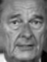

11


In [244]:
# display first image in val data batch and its label -- just for validation
first_batch = next(val_data_generator)
display(keras.preprocessing.image.array_to_img(first_batch[0][0] * 255))
print(first_batch[1][0])

val_data_generator = datagen.flow(val_images, val_labels, batch_size=64, shuffle=True) # reset val_data_generator

In [245]:
# Xception model from https://keras.io/examples/vision/image_classification_from_scratch/#using-image-data-augmentation

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=IMAGE_SIZE + (1, ), num_classes=len(frequencies))

In [246]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.legacy.Adam(1e-3), # legacy for m1 support
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_data_generator,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_data_generator,
)

Epoch 1/10
14/14 [==============================] - 10s 649ms/step - loss: 2.3501 - accuracy: 0.1632 - val_loss: 2.4677 - val_accuracy: 0.1318
Epoch 2/10
14/14 [==============================] - 8s 598ms/step - loss: 2.0732 - accuracy: 0.2797 - val_loss: 2.4673 - val_accuracy: 0.1500
Epoch 3/10
14/14 [==============================] - 9s 611ms/step - loss: 1.5942 - accuracy: 0.4566 - val_loss: 2.4750 - val_accuracy: 0.1500
Epoch 4/10
14/14 [==============================] - 9s 664ms/step - loss: 1.1788 - accuracy: 0.6016 - val_loss: 2.4781 - val_accuracy: 0.1500
Epoch 5/10
14/14 [==============================] - 9s 623ms/step - loss: 0.8698 - accuracy: 0.7123 - val_loss: 2.4781 - val_accuracy: 0.1500
Epoch 6/10
14/14 [==============================] - 9s 623ms/step - loss: 0.5981 - accuracy: 0.7808 - val_loss: 2.4814 - val_accuracy: 0.1500
Epoch 7/10
14/14 [==============================] - 9s 679ms/step - loss: 0.4963 - accuracy: 0.8436 - val_loss: 2.4875 - val_accuracy: 0.1500
Epoch